<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Load-and-tokenize-data" data-toc-modified-id="Load-and-tokenize-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and tokenize data</a></span></li><li><span><a href="#Verify-tokenization/padding" data-toc-modified-id="Verify-tokenization/padding-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Verify tokenization/padding</a></span></li><li><span><a href="#Split-data-into-train-and-validation-sets" data-toc-modified-id="Split-data-into-train-and-validation-sets-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Split data into train and validation sets</a></span></li><li><span><a href="#Verify-split" data-toc-modified-id="Verify-split-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Verify split</a></span></li><li><span><a href="#Define-shared-model-parameters" data-toc-modified-id="Define-shared-model-parameters-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define shared model parameters</a></span></li><li><span><a href="#Baseline-LSTM-model" data-toc-modified-id="Baseline-LSTM-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Baseline LSTM model</a></span></li><li><span><a href="#Test-baseline-LSTM-model" data-toc-modified-id="Test-baseline-LSTM-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Test baseline LSTM model</a></span></li><li><span><a href="#BiLSTM-model" data-toc-modified-id="BiLSTM-model-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>BiLSTM model</a></span></li><li><span><a href="#Test-BiLSTM-model" data-toc-modified-id="Test-BiLSTM-model-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Test BiLSTM model</a></span></li><li><span><a href="#Pytorch-Implementation" data-toc-modified-id="Pytorch-Implementation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Pytorch Implementation</a></span></li><li><span><a href="#Test-Area" data-toc-modified-id="Test-Area-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Test Area</a></span></li></ul></div>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
# %cd /content/drive/My Drive/Colab Notebooks/accent/src

### Import modules

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.ticker as ticker, random
from utils import process_raw, generate_input, get_max_len, process_data, convert
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LSTM, TimeDistributed, RepeatVector, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


### Load and tokenize data

In [2]:
# Load raw data and read first 100000 lines with 25 or less words
data = '../data/raw/raw_train.txt'
counter = 0
max_seq_len = 25 # To change to 35 in future iterations
no_seq = 100000
raw_data = []

with open(data, 'r', encoding='utf-8') as f:    
    while counter != no_seq:
        line = f.readline()
        if len(line.split()) <= max_seq_len:
            raw_data.append(line)
            counter += 1
        else:
            pass

In [3]:
raw_data[10]

"tên lãnh thổ này được đặt theo sông yukon , yukon có nghĩa `` sông vĩ đại '' trong tiếng gwich ’ in .\n"

In [4]:
# Shuffle raw data prior to processing
np.random.shuffle(raw_data)

# Process raw and input data
processed_raw = process_raw(raw_data)
processed_inp = [generate_input(seq) for seq in processed_raw]

In [5]:
# Tokenize/pad input and target data, generates corresponding tokenizers
tokenized_input, input_tokenizer, tokenized_target, target_tokenizer = process_data(processed_input=processed_inp, processed_target=processed_raw, pad_len=max_seq_len)

KeyboardInterrupt: 

In [ ]:
# Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
tokenized_target = tokenized_target.reshape(*tokenized_target.shape, 1)

### Verify tokenization/padding

In [ ]:
convert(input_tokenizer, tokenized_input[10])

In [ ]:
convert(target_tokenizer, tokenized_target[10].reshape(1, tokenized_target[10].shape[0])[0])

### Split data into train and validation sets

In [ ]:
train_data_len = round((.8 * no_seq))
val_test_data_len = round((.1 * no_seq))

In [ ]:
train_x, train_y = tokenized_input[:train_data_len], tokenized_target[:train_data_len]
val_x, val_y = tokenized_input[train_data_len:(train_data_len+val_test_data_len)], tokenized_target[train_data_len:(train_data_len+val_test_data_len)]
test_x, test_y = tokenized_input[-val_test_data_len:], tokenized_target[-val_test_data_len:]

### Verify split

In [ ]:
print('Train X: {} sequences, Train Y: {} sequences'.format(len(train_x), len(train_y)))

In [ ]:
print('Val X: {} sequences, Val Y: {} sequences'.format(len(val_x), len(val_y)))

In [ ]:
print('Test X: {} sequences, Test Y: {} sequences'.format(len(test_x), len(test_y)))

In [ ]:
convert(input_tokenizer, train_x[-1])

In [ ]:
convert(target_tokenizer, train_y[-1].reshape(1, train_y[-1].shape[0])[0])

In [ ]:
convert(input_tokenizer, val_x[0])

In [ ]:
convert(target_tokenizer, val_y[0].reshape(1, val_y[0].shape[0])[0])

In [ ]:
convert(input_tokenizer, val_x[-1])

In [ ]:
convert(target_tokenizer, val_y[-1].reshape(1, val_y[-1].shape[0])[0])

In [ ]:
convert(input_tokenizer, test_x[0])

In [ ]:
convert(target_tokenizer, test_y[0].reshape(1, test_y[0].shape[0])[0])

### Define shared model parameters

In [ ]:
batch_size = 64
embedding_dim = 256
units = 512
input_vocab_size = len(input_tokenizer.word_index)+1
target_vocab_size = len(target_tokenizer.word_index)+1

In [ ]:
input_vocab_size

In [ ]:
target_vocab_size

### Baseline LSTM model

In [27]:
model = Sequential()
model.add(Embedding(input_vocab_size, units, input_length=max_seq_len, mask_zero=True))
model.add(LSTM(units))
model.add(RepeatVector(max_seq_len))
model.add(LSTM(units, return_sequences=True))
model.add(TimeDistributed(Dense(target_vocab_size, activation='softmax')))
model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()

W0905 23:42:48.025320  2412 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0905 23:42:48.048259  2412 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0905 23:42:48.242758  2412 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 512)           16635904  
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 25, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 512)           2099200   
_________________________________________________________________
time_distributed (TimeDistri (None, 25, 36789)         18872757  
Total params: 39,707,061
Trainable params: 39,707,061
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 512)           16635904  
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 25, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 512)           2099200   
_________________________________________________________________
time_distributed (TimeDistri (None, 25, 36789)         18872757  
Total params: 39,707,061
Trainable params: 39,707,061
Non-trainable params: 0
_________________________________________________________________


In [29]:
chkpt = ModelCheckpoint(filepath='../models/baseline_best.h5', monitor='val_loss', verbose=1, 
                        save_best_only=True, mode='min')
earlys = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=train_x, y=train_y, 
                    batch_size=batch_size, epochs=1000, verbose=1, 
                    shuffle=True, validation_data=(val_x, val_y), callbacks=[chkpt, earlys])

Train on 80000 samples, validate on 10000 samples
Epoch 1/1000
79936/80000 [============================>.] - ETA: 0s - loss: 5.4733 - acc: 0.3859
Epoch 00001: val_loss improved from inf to 4.53369, saving model to ../models/baseline_best.h5
80000/80000 [==============================] - 288s 4ms/sample - loss: 5.4730 - acc: 0.3859 - val_loss: 4.5337 - val_acc: 0.4045
Epoch 2/1000
79936/80000 [============================>.] - ETA: 0s - loss: 4.4207 - acc: 0.4066
Epoch 00002: val_loss improved from 4.53369 to 4.20829, saving model to ../models/baseline_best.h5
80000/80000 [==============================] - 276s 3ms/sample - loss: 4.4206 - acc: 0.4066 - val_loss: 4.2083 - val_acc: 0.4172
Epoch 3/1000
79936/80000 [============================>.] - ETA: 0s - loss: 3.9799 - acc: 0.4306
Epoch 00003: val_loss improved from 4.20829 to 3.71876, saving model to ../models/baseline_best.h5
80000/80000 [==============================] - 277s 3ms/sample - loss: 3.9798 - acc: 0.4306 - val_loss: 3.71

### Test baseline LSTM model

W0906 01:38:49.714977  2412 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0906 01:38:49.715975  2412 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0906 01:38:49.716972  2412 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Inst

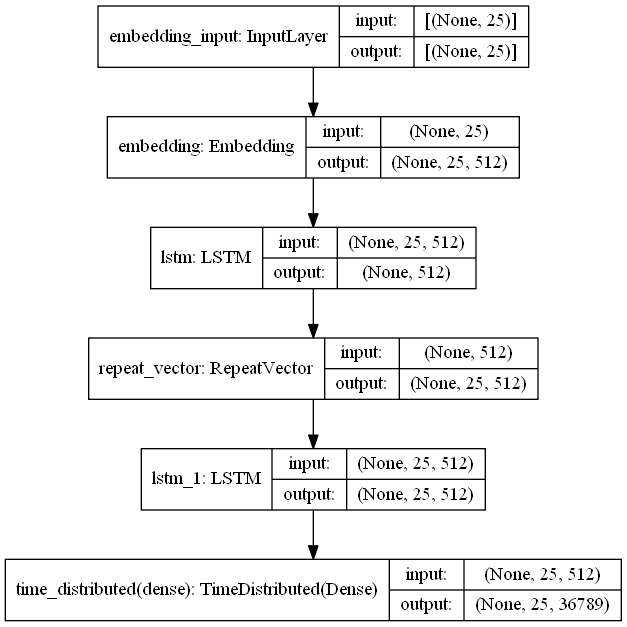

In [30]:
model = load_model('../models/baseline_best.h5')
plot_model(model=model, to_file='../models/baseline_best.png', show_shapes=True)

In [31]:
testing = test_x[:3000]

In [32]:
output_pred = model.predict_classes(testing)

In [33]:
output_pred[:5]

array([[   20,   819,   262,    11,     5,   412,  1217,  1040,   203,
          298,    24,     6,     9, 10373,   192,   135,   135,   240,
          240,   348,   347,     0,     0,     0,     0],
       [   28,     1,     7,   351,   110,   437,   969,    48,    28,
           22,     8,     7,   204,   143,     6,   467,   148,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    8,    23,    11,    60,     4,    54,   669,  1524,  1524,
         1286,     3,     3,     3,     1,     1,   296,   107,     8,
            6,   113,   107,   229,     0,     0,     0],
       [   79,   462,  2190,     5,   318,   226,   101,  1501,    79,
           85,  3248,  1069,   677,     2,   116,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [   52,     1,    15,   956,   176,   404,   320,    43,   508,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]],

In [34]:
print('Input text:')
convert(input_tokenizer, testing[10])

Input text:
Tokenized Data: [ 25 505   6  55 156  63   4   2  81 165 151 418  21  17 116  18  83  79
 203  59   3  98  53   0   0]


Original Data: ['ong', 'gianh', 'duoc', 'nhieu', 'giai', 'thuong', 'va', 'co', 'moi', 'lien', 'he', 'tot', 'voi', 'nhung', 'phap', 'su', 'dang', 'chu', 'y', 'nhat', 'cua', 'thoi', 'dai']


In [35]:
print('Model prediction:')
convert(target_tokenizer, output_pred[10])

Model prediction:
Tokenized Data: [ 15 701   5  30 148 867   3   4 927 133 102 499  13 459 927 318 318 318
 211  46  62  62  57   0   0]


Original Data: ['ông', 'giành', 'được', 'nhiều', 'giải', 'thưởng', 'và', 'có', 'mối', 'liên', 'hành', 'tốt', 'với', 'mọi', 'mối', 'biểu', 'biểu', 'biểu', 'ý', 'nhất', 'thời', 'thời', 'đại']


In [36]:
print('Ground truth target:')
convert(target_tokenizer, test_y[10].reshape(1, test_y[10].shape[0])[0])

Ground truth target:
Tokenized Data: [ 15 701   5  30 148 867   3   4 927 133 118 499  13  20  67 134 696 621
 211  46   2  62  57   0   0]


Original Data: ['ông', 'giành', 'được', 'nhiều', 'giải', 'thưởng', 'và', 'có', 'mối', 'liên', 'hệ', 'tốt', 'với', 'những', 'pháp', 'sư', 'đáng', 'chú', 'ý', 'nhất', 'của', 'thời', 'đại']


In [37]:
model.evaluate(x=output_pred, y=test_y[:3000], batch_size=batch_size)

3000/3000 [==============================] - 5s 2ms/sample - loss: 8.9858 - acc: 0.3972


[8.98583053334554, 0.39717335]

In [38]:
model.metrics_names

['loss', 'acc']

In [39]:
# Test with random text
msg = ['Khoan no cua KH se den han vao 01/08/2019. So tien  2.999.898 VND, TK 12345678912. Thong tin chi tiet, lien he 1900636633. Cam on']
msg = process_raw(msg)
msg_tked = input_tokenizer.texts_to_sequences(msg)
msg_tked = pad_sequences(msg_tked, padding='post', maxlen=max_seq_len)

In [40]:
convert(input_tokenizer, msg_tked[0])

Tokenized Data: [  656   106     3  2062   240    36   239    38    28    77   196  6096
 16962  3824    67   242    54   484   165   151   294   504     0     0
     0]


Original Data: ['khoan', 'no', 'cua', 'kh', 'se', 'den', 'han', 'vao', 'so', 'tien', '2', '999', '898', 'tk', 'thong', 'tin', 'chi', 'tiet', 'lien', 'he', 'cam', 'on']


In [41]:
msg_pred = model.predict_classes(msg_tked)

In [42]:
convert(target_tokenizer, msg_pred[0])

Tokenized Data: [1040  884  267 1326  195   24  577   21   23    9    9 3811 9927  739
  647  270   60   60    8  118  659  772    0    0    0]


Original Data: ['nhằm', 'nổ', 'bởi', 'g', 'sẽ', 'đến', 'hạn', 'vào', 'số', 'năm', 'năm', 'international', 'kbits', 'the', 'tín', 'tin', 'chỉ', 'chỉ', 'trong', 'hệ', 'cảm', 'cầm']


### BiLSTM model

In [43]:
model = Sequential()
model.add(Embedding(input_vocab_size, units, input_length=max_seq_len, mask_zero=True))
model.add(Bidirectional(LSTM(units)))
model.add(RepeatVector(max_seq_len))
model.add(Bidirectional(LSTM(units, return_sequences=True)))
model.add(TimeDistributed(Dense(target_vocab_size, activation='softmax')))
model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 512)           16635904  
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              4198400   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 25, 1024)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 1024)          6295552   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 36789)         37708725  
Total params: 64,838,581
Trainable params: 64,838,581
Non-trainable params: 0
_________________________________________________________________


In [44]:
chkpt = ModelCheckpoint(filepath='../models/blstm_best.h5', monitor='val_loss', verbose=1, 
                        save_best_only=True, mode='min')
earlys = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=train_x, y=train_y, 
                    batch_size=batch_size, epochs=1000, verbose=1, 
                    shuffle=True, validation_data=(val_x, val_y), callbacks=[chkpt, earlys])

Train on 80000 samples, validate on 10000 samples
Epoch 1/1000
79936/80000 [============================>.] - ETA: 0s - loss: 4.5937 - acc: 0.3983
Epoch 00001: val_loss improved from inf to 4.39468, saving model to ../models/blstm_best.h5
80000/80000 [==============================] - 427s 5ms/sample - loss: 4.5935 - acc: 0.3983 - val_loss: 4.3947 - val_acc: 0.4061
Epoch 2/1000
79936/80000 [============================>.] - ETA: 0s - loss: 4.3811 - acc: 0.4031
Epoch 00002: val_loss improved from 4.39468 to 4.26277, saving model to ../models/blstm_best.h5
80000/80000 [==============================] - 425s 5ms/sample - loss: 4.3812 - acc: 0.4031 - val_loss: 4.2628 - val_acc: 0.4121
Epoch 3/1000
79936/80000 [============================>.] - ETA: 0s - loss: 4.1230 - acc: 0.4157
Epoch 00003: val_loss improved from 4.26277 to 3.97620, saving model to ../models/blstm_best.h5
80000/80000 [==============================] - 425s 5ms/sample - loss: 4.1231 - acc: 0.4157 - val_loss: 3.9762 - val_

80000/80000 [==============================] - 424s 5ms/sample - loss: 0.4020 - acc: 0.9110 - val_loss: 1.1394 - val_acc: 0.7829
Epoch 27/1000
79936/80000 [============================>.] - ETA: 0s - loss: 0.3658 - acc: 0.9208
Epoch 00027: val_loss improved from 1.13936 to 1.13920, saving model to ../models/blstm_best.h5
80000/80000 [==============================] - 424s 5ms/sample - loss: 0.3657 - acc: 0.9208 - val_loss: 1.1392 - val_acc: 0.7844
Epoch 28/1000
79936/80000 [============================>.] - ETA: 0s - loss: 0.4630 - acc: 0.8961
Epoch 00028: val_loss did not improve from 1.13920
80000/80000 [==============================] - 419s 5ms/sample - loss: 0.4630 - acc: 0.8961 - val_loss: 1.2689 - val_acc: 0.7604
Epoch 29/1000
79936/80000 [============================>.] - ETA: 0s - loss: 0.5255 - acc: 0.8765
Epoch 00029: val_loss did not improve from 1.13920
80000/80000 [==============================] - 419s 5ms/sample - loss: 0.5256 - acc: 0.8765 - val_loss: 1.3409 - val_acc:

### Test BiLSTM model

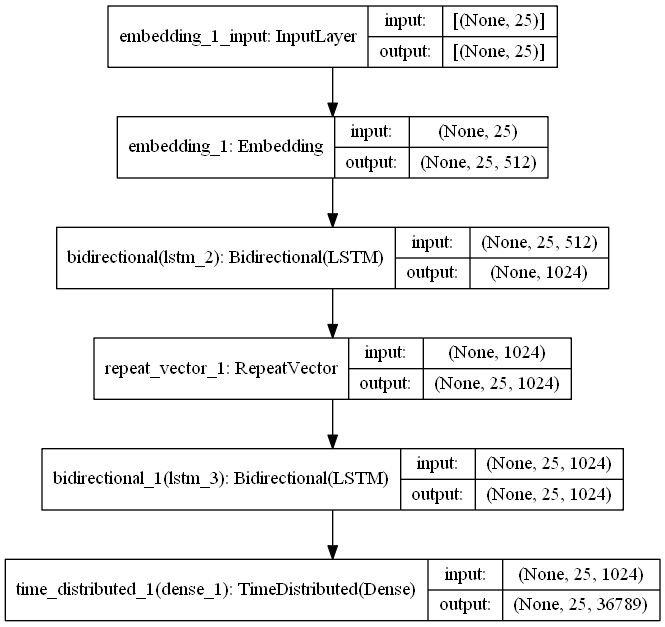

In [45]:
model = load_model('../models/blstm_best.h5')
plot_model(model=model, to_file='../models/blstm_best.png', show_shapes=True)

In [46]:
testing = test_x[:3000]

In [47]:
predict = model.predict_classes(testing)

In [48]:
output_pred[:5]

array([[   20,   819,   262,    11,     5,   412,  1217,  1040,   203,
          298,    24,     6,     9, 10373,   192,   135,   135,   240,
          240,   348,   347,     0,     0,     0,     0],
       [   28,     1,     7,   351,   110,   437,   969,    48,    28,
           22,     8,     7,   204,   143,     6,   467,   148,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    8,    23,    11,    60,     4,    54,   669,  1524,  1524,
         1286,     3,     3,     3,     1,     1,   296,   107,     8,
            6,   113,   107,   229,     0,     0,     0],
       [   79,   462,  2190,     5,   318,   226,   101,  1501,    79,
           85,  3248,  1069,   677,     2,   116,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [   52,     1,    15,   956,   176,   404,   320,    43,   508,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]],

In [49]:
print('Input text:')
convert(input_tokenizer, testing[10])

Input text:
Tokenized Data: [ 25 505   6  55 156  63   4   2  81 165 151 418  21  17 116  18  83  79
 203  59   3  98  53   0   0]


Original Data: ['ong', 'gianh', 'duoc', 'nhieu', 'giai', 'thuong', 'va', 'co', 'moi', 'lien', 'he', 'tot', 'voi', 'nhung', 'phap', 'su', 'dang', 'chu', 'y', 'nhat', 'cua', 'thoi', 'dai']


In [50]:
print('Model prediction:')
convert(target_tokenizer, output_pred[10])

Model prediction:
Tokenized Data: [ 15 701   5  30 148 867   3   4 927 133 102 499  13 459 927 318 318 318
 211  46  62  62  57   0   0]


Original Data: ['ông', 'giành', 'được', 'nhiều', 'giải', 'thưởng', 'và', 'có', 'mối', 'liên', 'hành', 'tốt', 'với', 'mọi', 'mối', 'biểu', 'biểu', 'biểu', 'ý', 'nhất', 'thời', 'thời', 'đại']


In [51]:
print('Ground truth target:')
convert(target_tokenizer, test_y[10].reshape(1, test_y[10].shape[0])[0])

Ground truth target:
Tokenized Data: [ 15 701   5  30 148 867   3   4 927 133 118 499  13  20  67 134 696 621
 211  46   2  62  57   0   0]


Original Data: ['ông', 'giành', 'được', 'nhiều', 'giải', 'thưởng', 'và', 'có', 'mối', 'liên', 'hệ', 'tốt', 'với', 'những', 'pháp', 'sư', 'đáng', 'chú', 'ý', 'nhất', 'của', 'thời', 'đại']


In [52]:
model.evaluate(x=testing, y=test_y[:3000], batch_size=batch_size)

3000/3000 [==============================] - 6s 2ms/sample - loss: 1.1497 - acc: 0.7793


[1.149676704088847, 0.7792533]

In [53]:
model.metrics_names

['loss', 'acc']

In [54]:
# Test with random text
msg = ['Khoan no cua KH se den han vao 01/08/2019. So tien  2.999.898 VND, TK 12345678912. Thong tin chi tiet, lien he 1900636633. Cam on']
msg = process_raw(msg)
msg_tked = input_tokenizer.texts_to_sequences(msg)
msg_tked = pad_sequences(msg_tked, padding='post', maxlen=max_seq_len)

In [55]:
msg_pred = model.predict_classes(msg_tked)

In [56]:
convert(target_tokenizer, msg_pred[0])

Tokenized Data: [1394  918    2 4843 4843  808   19  918   35   35  139  196  593  149
  149   60  323  635  133  118  131 1429    0    0    0]


Original Data: ['khoản', 'đo', 'của', 'wb', 'wb', 'đổ', 'từ', 'đo', 'khi', 'khi', '2', 'hàng', 'phiên', 'thông', 'thông', 'chỉ', 'chi', 'tiết', 'liên', 'hệ', 'điều', 'ôn']


### Pytorch Implementation

In [1]:
# Import modules 
import torch, torch.nn as nn, torch.nn.functional as F, numpy as np, \
        matplotlib.pyplot as plt, matplotlib.ticker as ticker, pandas as pd, random
from torch.utils.data import DataLoader, Dataset
from torch import optim
from utils import process_raw, generate_input, get_max_len, process_data, convert
np.random.seed(50)

Using TensorFlow backend.


In [2]:
class test_dataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inp = row.tk_input
        tar = row.tk_target
        return {'input':inp, 'target':tar}

In [3]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [4]:
# Define data/model paths
data_file = '../data/raw/raw_train.txt'
counter = 0
max_seq_len = 40
no_seq = 1000
raw_data = []

In [5]:
# Load dataset
# Load raw data and read first 100000 lines with 40 or less words
with open(data_file, 'r', encoding='utf-8') as f:    
    while counter != no_seq:
        line = f.readline()
        if len(line.split()) <= max_seq_len:
            raw_data.append(line)
            counter += 1
        else:
            pass

In [6]:
# Process dataset
# Shuffle raw data prior to processing
np.random.shuffle(raw_data)

# Process raw and input data
filtered_raw = process_raw(raw_data)
processed_inp = [generate_input(seq) for seq in filtered_raw]

data = pd.DataFrame({'input': processed_inp, 'target': filtered_raw})

In [7]:
# Tokenize/pad input and target data, generates corresponding tokenizers
tokenized_input, input_tokenizer, tokenized_target, target_tokenizer = process_data(processed_input=data.input, 
                                                            processed_target=data.target, pad_len=max_seq_len)

In [8]:
inp_vocab_sz = len(input_tokenizer.index_word)
tar_vocab_sz = len(target_tokenizer.index_word)

print(inp_vocab_sz)
print(tar_vocab_sz)

1700
2515


In [9]:
tokenized_input = [seq for seq in tokenized_input]
tokenized_target = [seq for seq in tokenized_target]

In [10]:
data['tk_input'] = tokenized_input
data['tk_target'] = tokenized_target
data = data[['input', 'tk_input', 'target', 'tk_target']]

In [11]:
data.to_excel('./processed_data.xlsx', index=False)

In [12]:
final_data = data.filter(items=['tk_input', 'tk_target'])

In [13]:
final_data.head(5)

,tk_input,tk_target
0,"[525, 526, 1, 903, 1, 485, 24, 56, 154, 11, 40...","[736, 737, 1, 1395, 1, 658, 24, 45, 136, 9, 50..."
1,"[4, 64, 157, 187, 271, 6, 23, 30, 98, 328, 3, ...","[4, 203, 147, 159, 257, 7, 49, 17, 103, 347, 3..."
2,"[32, 157, 38, 57, 62, 25, 46, 5, 15, 188, 279,...","[41, 147, 31, 274, 53, 18, 423, 8, 14, 168, 46..."
3,"[10, 143, 206, 430, 22, 118, 3, 16, 32, 98, 83...","[10, 122, 291, 543, 58, 93, 3, 25, 41, 103, 18..."
4,"[35, 138, 373, 6, 20, 431, 211, 247, 24, 33, 5...","[22, 141, 424, 7, 26, 544, 864, 739, 24, 176, ..."


In [14]:
train_data_len = round((.8 * no_seq))
val_test_data_len = round((.1 * no_seq))

In [15]:
train_data = final_data[:train_data_len]
val_data = final_data[train_data_len:(train_data_len+val_test_data_len)]
test_data = final_data[-val_test_data_len:]

In [16]:
# train_dataset = test_dataset(train_data)
# train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)
# val_dataset = test_dataset(val_data)
# val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True, drop_last=True)

In [17]:
# def get_data(dataloader):
#     train_dict = {}
#     for x in dataloader:
#         for y,z in x.items():
#             train_dict[y] = x[y]
#         yield train_dict

In [18]:
# for x,y in enumerate(h):
#     print(x)
#     print(y)
#     break

In [19]:
# breaks = [data for _, data in enumerate(dataloader)]

In [27]:
# Set training to GPU if available
device = torch.device("cpu")
print('Using device: {}'.format(device))

# Initialize encoder and decoder
hidden_sz = 256
encoder = EncoderRNN(inp_vocab_sz, hidden_sz)
decoder = DecoderRNN(hidden_sz, tar_vocab_sz)

Using device: cpu


In [21]:
encoder.to(device)

EncoderRNN(
  (embedding): Embedding(1700, 256)
  (gru): GRU(256, 256)
)

In [22]:
decoder.to(device)

DecoderRNN(
  (embedding): Embedding(2515, 256)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2515, bias=True)
  (softmax): LogSoftmax()
)

In [36]:
# Add end of sentence token to target tokenizer
target_tokenizer.index_word[2514] = '<s>'
eos = 2514

In [37]:
# Define loss function
criterion = nn.NLLLoss()

# Define optimizer
encoder_opti = optim.Adam(encoder.parameters(), lr=0.001)
decoder_opti = optim.Adam(decoder.parameters(), lr=0.001)

In [40]:
teacher_forcing_ratio = 0.5

def train(inputs, target, encoder, decoder, encoder_opti, decoder_opti, criterion, max_seq_len):
    encoder_hidden = encoder.initHidden()
    encoder_outputs = torch.zeros(max_seq_len, encoder.hidden_size, device=device)
    
    # setup: batch generator, set loss and acc to 0, set train mode on
    running_loss = 0.0
    running_acc = 0.0
    
    # Set encoder and decoder to training mode
    encoder.train()
    decoder.train()
    
    # Zero gradients
    encoder_opti.zero_grad()
    decoder_opti.zero_grad()
    
    for i in range(inputs.shape[0]):
        encoder_output, encoder_hidden = encoder(inputs[i], encoder_hidden)
        encoder_outputs[i] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[eos]], device=device)
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for i in range(target.shape[0]):
#             decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            running_loss += criterion(decoder_output, target[i])
            decoder_input = target_tensor[i]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for i in range(target.shape[0]):
#             decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            running_loss += criterion(decoder_output, target[i])
            if decoder_input.item() == eos:
                break
    
    running_loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return running_loss.item() / len(target.shape[0])

In [42]:
# Training loop
epochs = 2

for epoch in range(epochs):
    for idx in range(len(train_data)):
        inp = torch.tensor(train_data.iloc[idx]['tk_input'], dtype=torch.long).to(device)
        print(inp)
        print(inp[0])
        tar = torch.tensor(train_data.iloc[idx]['tk_target'], dtype=torch.long).to(device)
        model_loss = train(inputs=inp, target=tar, encoder=encoder, decoder=decoder, encoder_opti=encoder_opti, \
                           decoder_opti=decoder_opti, criterion=criterion, max_seq_len=max_seq_len)
        print('Loss: {}'.format(model_loss))

tensor([525, 526,   1, 903,   1, 485,  24,  56, 154,  11, 409,   3,  10,  12,
          4,  37,   5,  15, 278,  97,  54,  16,  40, 108,   4, 527,  12, 454,
         45,  46,   1,   2,   0,   0,   0,   0,   0,   0,   0,   0])
tensor(525)


IndexError: dimension specified as 0 but tensor has no dimensions

In [24]:
avg_loss = []
avg_acc = []

for epoch_index in range(2):
    # Iterate over training dataset
    encoder_hidden = encoder.initHidden()
    encoder_outputs = torch.zeros(max_seq_len, encoder.hidden_size, device=device)
    
    # setup: batch generator, set loss and acc to 0, set train mode on
    running_loss = 0.0
    running_acc = 0.0
    
    # Set encoder and decoder to training mode
    encoder.train()
    decoder.train()
    
    for batch_index, batch_dict in enumerate(dataloader):
        # the training routine is these 5 steps:

        # --------------------------------------
        # step 1. zero the gradients
        encoder_opti.zero_grad()
        decoder_opti.zero_grad()

        # step 2. compute the output
        inp = batch_dict['input'].long().to(device)
        for i in range(inp):
            encoder_output, encoder_hidden = encoder(inp[i][i])
        
        tar = batch_dict['target'].long().to(device)
        print('Target Shape: {}'.format(tar.shape))
        print('Sample Target: {}'.format(tar[0]))
        
        y_pred = clf(x_in=inp)
        print('Prediction Shape: {}'.format(y_pred.shape))
        print('Sample Prediction: {}'.format(y_pred[0]))
        
        # step 3. compute the loss
        loss = criterion(y_pred, tar)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
        # -----------------------------------------
        # compute the accuracy
        acc_t = compute_accuracy(y_pred, tar)
        running_acc += (acc_t - running_acc) / (batch_index + 1)
    
    avg_loss.append(running_loss)
    avg_acc.append(running_acc)

print('Average loss: {}'.format(np.mean(avg_loss)))
print('Average accuracy: {}'.format(np.mean(avg_loss)))

Input Shape: torch.Size([64, 40])
Sample Input: tensor([  2,  81,  25,  64, 175,   5,  73, 208,   8, 221, 282,  46,  72, 281,
          5,  86,  10, 471,  10,   9,  27, 226,  34, 214, 125,  52, 215,  13,
          9,  10,  63, 210,   8,  64,  71,  10,   1,   3,   0,   0])
Target Shape: torch.Size([64, 40])
Sample Target: tensor([  2,  69,  25,  70, 454,   5, 108, 381,   6, 203, 280,  86,  58, 294,
          5,  62,  29, 809,  13,   7,  20, 192,  48, 353, 173,  39, 183,  67,
          7,  13,  54, 215,   6,  70,  57,  13,   1,   3,   0,   0])
Prediction Shape: torch.Size([64, 1701])
Sample Prediction: tensor([-29.5504, -15.8248, -29.2208,  ..., -17.8738, -23.5583, -22.8240],
       grad_fn=<SelectBackward>)


RuntimeError: multi-target not supported at /Users/distiller/project/conda/conda-bld/pytorch_1565272526878/work/aten/src/THNN/generic/ClassNLLCriterion.c:22

In [5]:
# Split dataset into train, val, test
train_data_len = int((.8 * no_seq))
val_test_data_len = int((.1 * no_seq))

train_x, train_y = tokenized_input[:train_data_len], tokenized_target[:train_data_len]
val_x, val_y = tokenized_input[train_data_len:(train_data_len+val_test_data_len)], \
                tokenized_target[train_data_len:(train_data_len+val_test_data_len)]
test_x, test_y = tokenized_input[-val_test_data_len:], tokenized_target[-val_test_data_len:]

In [6]:
# Define model parameters
batch_size = 64
shuffle_data = True
drop_last = True
no_of_batches = int(train_data_len / batch_size)

# Embedding layer output dimension
embedding_dim = 256

# Number of units for LSTM layers
units = 512

input_vocab_size = len(input_tokenizer.word_index)+1
target_vocab_size = len(target_tokenizer.word_index)+1

# Set training to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")